<a href="https://colab.research.google.com/github/dnguyend/StiefelGeodesic/blob/main/colab/StiefelLogarithmV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Workbook containing the algorithms and data generation for Logarithm map on the Stiefel manifold.

## Usage note: User can just view results in the notebook or can rerun on the colab environment. Colab hides some cells if the workbook is long, just click on the hidden group, the hidden cells will expand.

## eventually we will fold this repository to ManNullRange, but since we are trying to freeze development there for now, we will import the code we need from that project.

## For Stiefel manifolds, the main algorithms are in two functions log_lbfgs and log_descent. To view the code the user can go to the github page, or simply type ??log_lbfgs, for example, in a new empty cell. We implemented the shooting algorithm in log_shooting_raw.



# Step 1: Download libraries. pymanopt and ManNullRange. Also download geomstat for comparision

In [5]:
!git clone  https://github.com/pymanopt/pymanopt.git
import sys
sys.path.append("/content/pymanopt")

Cloning into 'pymanopt'...
remote: Enumerating objects: 4127, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 4127 (delta 0), reused 0 (delta 0), pack-reused 4124
Receiving objects: 100% (4127/4127), 899.14 KiB | 12.66 MiB/s, done.
Resolving deltas: 100% (2876/2876), done.


In [6]:
!git clone https://github.com/dnguyend/ManNullRange.git

Cloning into 'ManNullRange'...
remote: Enumerating objects: 253, done.
remote: Counting objects: 100% (253/253), done.
remote: Compressing objects: 100% (192/192), done.
remote: Total 253 (delta 164), reused 106 (delta 60), pack-reused 0
Receiving objects: 100% (253/253), 770.12 KiB | 8.85 MiB/s, done.
Resolving deltas: 100% (164/164), done.


In [2]:
!git clone https://github.com/dnguyend/StiefelGeodesic.git

Cloning into 'StiefelGeodesic'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 24 (delta 5), reused 16 (delta 4), pack-reused 0
Unpacking objects: 100% (24/24), done.


GEOMSTAT - we only use it for comparison.

In [3]:
!pip install geomstats

     |████████████████████████████████| 9.5 MB 4.4 MB/s 
     |████████████████████████████████| 294 kB 50.9 MB/s 
  Attempting uninstall: joblib
    Found existing installation: joblib 1.0.1
    Uninstalling joblib-1.0.1:
      Successfully uninstalled joblib-1.0.1


# Then import the library. As a sanity check we show the algorithm works for the sphere, a Stiefel manifold with $p=1$ column.

In [7]:
import numpy as np
from numpy.random import (randint, randn)
from numpy import zeros, zeros_like, trace, allclose

from ManNullRange.manifolds.RealStiefel import RealStiefel
from ManNullRange.manifolds.tools import asym, vecah, unvecah
from ManNullRange.tests.test_tools import (
    check_zero, make_sym_pos, random_orthogonal, timeout,
    TimeoutError)
from StiefelGeodesic.manifolds.LogStiefel import log_descent, log_lbfgs
from StiefelGeodesic.manifolds.tools import sbmat, linf


In [8]:
def compare_with_sphere(m, NN):
    import numpy.linalg as la
    from numpy import bmat
    from scipy.linalg import expm, expm_frechet
    from ManNullRange.manifolds.tools import (
        vecah, unvecah, asym)
    from pymanopt.manifolds import Sphere
    
    np.random.seed(0)    
    alpha = np.array([1, .8])
    radius = 1.5
    d = 1
    # m, d = 3, 1
    man = RealStiefel(m, d, alpha=alpha, log_stats=True)

    sp = Sphere(m)
    
    X = sp.rand()

    cnt = 0
    # NN = 100
    fvals_arr = np.zeros(NN)
    for i in range(NN):
        xi = sp.randvec(X)
        X1 = sp.exp(X, radius*np.pi*xi)
        v1 = sp.dist(X, X1)
        lgs, iters, fvals, fjacs, done = log_descent(man, X.reshape(-1, 1), X1.reshape(-1, 1))
        fvals_arr[i] = fvals + fjacs*3
        v2 = man.norm(X.reshape(-1, 1), lgs)
        if np.abs(v1 - v2) > 1e-4:
            print(i, v1, v2, v1-v2, (v1+v2)/np.pi)
            print(check_zero(X[None, :]@lgs))
            X1a = man.exp(X[:, None], lgs)
            print(check_zero(X1a.T@X1a - np.eye(X1a.shape[1])))
            print(sts)
            cnt += 1
    print('Sphere in R^%d with %d samples ' % (m, NN))        
    print('number of mismatch %d. Percent of mismatch  %f ' % (cnt, cnt/NN))
    print("avg weighted fvals %f" % fvals_arr.mean())
    
compare_with_sphere(30, 100)

Sphere in R^30 with 100 samples 
number of mismatch 0. Percent of mismatch  0.000000 
avg weighted fvals 89.790000


In [10]:
def compare_with_sphere_lbfgs(m, NN):
    import numpy.linalg as la
    from numpy import bmat
    from scipy.linalg import expm, expm_frechet
    from ManNullRange.manifolds.tools import (
        vecah, unvecah, asym)
    from pymanopt.manifolds import Sphere
    
    np.random.seed(0)    
    alpha = np.array([1, .8])
    radius = 1.5
    d = 1
    # m, d = 3, 1
    man = RealStiefel(m, d, alpha=alpha, log_stats=True)

    sp = Sphere(m)
    
    X = sp.rand()

    cnt = 0
    # NN = 100
    fvals_arr = np.zeros(NN)
    for i in range(NN):
        xi = sp.randvec(X)
        X1 = sp.exp(X, radius*np.pi*xi)
        v1 = sp.dist(X, X1)

        lgs, sts = log_lbfgs(man, X.reshape(-1, 1), X1.reshape(-1, 1))
        fvals_arr[i] = sts['funcCount']*3
        v2 = man.norm(X.reshape(-1, 1), lgs)
        if np.abs(v1 - v2) > 1e-4:
            print(i, v1, v2, v1-v2, (v1+v2)/np.pi)
            print(check_zero(X[None, :]@lgs))
            X1a = man.exp(X[:, None], lgs)
            print(check_zero(X1a.T@X1a - np.eye(X1a.shape[1])))
            cnt += 1
    print('Sphere in R^%d with %d samples ' % (m, NN))        
    print('number of mismatch %d. Percent of mismatch  %f ' % (cnt, cnt/NN))
    print("avg weighted fvasl %f" % fvals_arr.mean())
    
compare_with_sphere_lbfgs(30, 100)

Sphere in R^30 with 100 samples 
number of mismatch 0. Percent of mismatch  0.000000 
avg weighted fvasl 15.000000


# Show length of closed geodesics. On a sphere, every geodesics is closed. On a Stiefel manifold we show one family of closed geodesics, but there are also sphere-like geodesics

In [11]:
# CHECK FORMULA FOR CLOSED GEODESIC.
# Closed geodesics are geodesics that comeback to the original point
def closed_geodesics(m , d):        
    import numpy.linalg as la
    from numpy import bmat
    from scipy.linalg import expm, expm_frechet
    from ManNullRange.manifolds.tools import (
        vecah, unvecah, asym, sym)

    # m, d = (1000, 40)
    # m, d = (4, 2)
    alpha = np.zeros(2)
    alpha[0] = 1
    alpha[1] = 1
    man = RealStiefel(m, d, alpha=alpha, log_stats=True)
    for alx in range(1, 10):
        man.alpha[1] = alx*.000001
        X = man.rand()
        A = np.zeros((d, d))
        A[0, 1] = - 2*np.pi
        A[1, 0] = 2*np.pi
        eta = X@A
        if check_zero(man.exp(X, eta) - X) > 1e-5:
            print("not good %f" % man.alpha[1])
        print('checking formula for close geodesics m=%d d=%d alpha = %f' %(m, d, man.alpha[1]))
        print('direct calc %f formula %f diff %f' %
            (man.norm(X, eta), 2*np.pi*np.sqrt(2*man.alpha[1]), man.norm(X, eta) - 2*np.pi*np.sqrt(2*man.alpha[1])))

closed_geodesics(4, 2)
closed_geodesics(100, 5)



checking formula for close geodesics m=4 d=2 alpha = 0.000001
direct calc 0.008886 formula 0.008886 diff -0.000000
checking formula for close geodesics m=4 d=2 alpha = 0.000002
direct calc 0.012566 formula 0.012566 diff -0.000000
checking formula for close geodesics m=4 d=2 alpha = 0.000003
direct calc 0.015391 formula 0.015391 diff 0.000000
checking formula for close geodesics m=4 d=2 alpha = 0.000004
direct calc 0.017772 formula 0.017772 diff -0.000000
checking formula for close geodesics m=4 d=2 alpha = 0.000005
direct calc 0.019869 formula 0.019869 diff 0.000000
checking formula for close geodesics m=4 d=2 alpha = 0.000006
direct calc 0.021766 formula 0.021766 diff -0.000000
checking formula for close geodesics m=4 d=2 alpha = 0.000007
direct calc 0.023510 formula 0.023510 diff -0.000000
checking formula for close geodesics m=4 d=2 alpha = 0.000008
direct calc 0.025133 formula 0.025133 diff 0.000000
checking formula for close geodesics m=4 d=2 alpha = 0.000009
direct calc 0.026657 

# We offer two algorithms to compute log function. The following section compare them


In [12]:
def compare_two_logs(m, d, NN):
    import numpy.linalg as la
    from numpy import bmat
    from scipy.linalg import expm, expm_frechet
    from ManNullRange.manifolds.tools import (
        vecah, unvecah, asym, sym)
    
    alpha = np.zeros(2)
    alpha[0] = 1
    alpha[1] = 1
    man = RealStiefel(
        m, d, alpha=alpha, log_stats=True)
    
    mean_sts = {}
    klist = ['niter', 'nfvals', 'success', 'dist', 'improve']
    fts = dict((kk, 1) for kk in klist)
    fts['success'] = 100

    for radius in [.5, .99, 1.3]:
        rkey = 'rd%0.2f' % radius
        mean_sts[rkey] = {}
        for alx in np.array([1, 5, 10, 12]):
            tots = dict((k, {0: 0, 1: 0}) for k in klist)        
            X = man.rand()        
            np.random.seed(0)            
            man.alpha[1] = alx*.1
            print('Doing %s %f' % (rkey, man.alpha[1]))
            cnt = 0
            all_sts = {}
            for i in range(NN):
                xi = man.randvec(X)
                X1 = man.exp(X, radius*np.pi*xi)
                lgs0, iter0, fvals, fjacs, done0 = log_descent(man, X, X1)
                lgs1, sts1 = log_lbfgs(man, X, X1)
                Norm0 = man.norm(X, (man.exp(X, lgs0) - X1))
                Norm1 = man.norm(X, (man.exp(X, lgs1) - X1))
                # print(sts1)
                msg0 = {'success': done0 or Norm0 < 1e-3, 'nfvals': fvals + fjacs*3, 'niter': iter0}
                msg1 = {'success': Norm1 < 1e-3, 'nfvals': sts1['funcCount']*3, 'niter': sts1['iterations']}
                # all_sts[i] = {0: sts0, 1: sts1}
                v0 = man.norm(X, lgs0)
                v1 = man.norm(X, lgs1)
                if Norm0 > 1e-3:
                    msg0['success'] = False
                elif v0 <= radius*np.pi + 1e-3:
                    tots['dist'][0] += 1
                    tots['improve'][0] += 1-man.norm(X, lgs0)/radius/np.pi
                if Norm1 > 1e-3:
                    msg1['success'] = False
                elif v1 <= radius*np.pi + 1e-3:
                    tots['dist'][1] += 1
                    tots['improve'][1] += 1-man.norm(X, lgs1)/radius/np.pi
                                        
                for kk in klist:
                    if kk in msg0:
                        tots[kk][0] += msg0[kk]
                    if kk in msg1:
                        tots[kk][1] += msg1[kk]
                # tots['dist'][0] += 
                # tots['dist'][1] += int(v1 <= radius*np.pi + 1e-3)

                if np.abs(v0 - v1) > 1e-3:
                    print('rkey=%s alx=%d i=%d v0=%f v1=%f v0-v1=%f (v0+v1)/pi=%f' %
                          (rkey, alx, i, v0, v1, v0-v1, (v0+v1)/np.pi))
                    print('check sym 0 %f' % check_zero(sym(X.T@lgs0)))
                    print('check sym 1 %f ' % check_zero(sym(X.T@lgs1)))
                    X1a = man.exp(X, lgs1)
                    print('check reach target %f' %
                          check_zero(X1a.T@X1a - np.eye(X1a.shape[1])))
                    print('status 0:')
                    print("cnt=%d done=%d" %(iter0, done0))
                    # print(sts0)
                    print('status 1:')
                    # print("cnt=%d done=%d" %(iter1, done1))
                    print(sts1)
                    # pdb.set_trace()
                    cnt += 1
            mean_sts[rkey][alx] = dict((kk, [tots[kk][0]/NN*fts[kk],
                                             tots[kk][1]/NN*fts[kk]])
                                       for kk in klist)
            print('Discepancy count %d percent %f ' % (cnt, cnt/NN))
        print(mean_sts[rkey])
    fname = 'tbl_stief_desc_r_al_m%d_d%d.p' % (
        m, d)
    np.savez_compressed(fname, mean_sts)
    return mean_sts
msts = compare_two_logs(m=1000, d=50, NN=50)

Doing rd0.50 0.100000
Discepancy count 0 percent 0.000000 
Doing rd0.50 0.500000
Discepancy count 0 percent 0.000000 
Doing rd0.50 1.000000
Discepancy count 0 percent 0.000000 
Doing rd0.50 1.200000
Discepancy count 0 percent 0.000000 
{1: {'niter': [10.12, 7.24], 'nfvals': [30.36, 28.44], 'success': [100.0, 100.0], 'dist': [1.0, 1.0], 'improve': [2.70614251007828e-10, 8.036344811834795e-10]}, 5: {'niter': [7.56, 5.2], 'nfvals': [22.68, 21.24], 'success': [100.0, 100.0], 'dist': [1.0, 1.0], 'improve': [1.5058774271992092e-09, -5.339630293477171e-11]}, 10: {'niter': [3.04, 2.0], 'nfvals': [9.12, 9.0], 'success': [100.0, 100.0], 'dist': [1.0, 1.0], 'improve': [-1.354472090042691e-16, -1.2114750091996029e-10]}, 12: {'niter': [5.34, 4.0], 'nfvals': [16.02, 15.0], 'success': [100.0, 100.0], 'dist': [1.0, 1.0], 'improve': [3.220463988817812e-09, -9.33916597389839e-10]}}
Doing rd0.99 0.100000
Discepancy count 0 percent 0.000000 
Doing rd0.99 0.500000
Discepancy count 0 percent 0.000000 
Doing

In [13]:
msts42 = compare_two_logs(m=4, d=2, NN=50)

Doing rd0.50 0.100000
rkey=rd0.50 alx=1 i=11 v0=1.570796 v1=3.488355 v0-v1=-1.917558 (v0+v1)/pi=1.610378
check sym 0 0.000000
check sym 1 0.000000 
check reach target 0.000000
status 0:
cnt=100 done=0
status 1:
{'iterations': 34, 'funcCount': 45, 'firstorderopt': 1.8387499952286057e-08, 'message': 'Directional Derivative below progTol'}
Discepancy count 1 percent 0.020000 
Doing rd0.50 0.500000
Discepancy count 0 percent 0.000000 
Doing rd0.50 1.000000
Discepancy count 0 percent 0.000000 
Doing rd0.50 1.200000
Discepancy count 0 percent 0.000000 
{1: {'niter': [88.56, 14.74], 'nfvals': [265.68, 49.62], 'success': [100.0, 100.0], 'dist': [1.0, 0.98], 'improve': [1.0649989024003048e-09, 1.3912922125491889e-09]}, 5: {'niter': [40.4, 11.88], 'nfvals': [121.2, 41.28], 'success': [100.0, 100.0], 'dist': [1.0, 1.0], 'improve': [8.488702318842911e-10, -4.343789417049493e-10]}, 10: {'niter': [23.78, 10.28], 'nfvals': [71.34, 36.3], 'success': [100.0, 100.0], 'dist': [1.0, 1.0], 'improve': [-1.8

Some codes to format the result to nice latex format

In [14]:
def print_tbl(mean_sts):
    header = [r'dist ($\pi$)', r'$\alpha$', r'\#Iteration', r'\#Calc',
              r'\%Succ', '\\%Improve', '\\%Not worse distance']
    radius = sorted(mean_sts)

    def print_block():
        for r in radius:
            for alf in sorted(mean_sts[r].keys()):
                ddc = mean_sts[r][alf]
                out_str = '%s & %0.2f & %0.2f/%0.2f & %.2f/%.2f &  %.f/%.f & %.f/%.f & %.f/%.f\\\\'
                print(
                    out_str % (
                        r[2:], alf / 10, ddc['niter'][0], ddc['niter'][1],
                        ddc['nfvals'][0],
                        ddc['nfvals'][1],
                        ddc['success'][0], ddc['success'][1],
                        np.abs(ddc['improve'][0]*100), np.abs(ddc['improve'][1]*100),
                        ddc['dist'][0]*100, ddc['dist'][1]*100))
    print('&'.join(header) + r'\\')
    print_block()
    

m1000_50 = np.load('tbl_stief_desc_r_al_m1000_d50.p.npz', allow_pickle=True)['arr_0'].tolist()
print_tbl(m1000_50)

m4_2 = np.load('tbl_stief_desc_r_al_m4_d2.p.npz', allow_pickle=True)['arr_0'].tolist()
print_tbl(m4_2)
    


dist ($\pi$)&$\alpha$&\#Iteration&\#Calc&\%Succ&\%Improve&\%Not worse distance\\
0.50 & 0.10 & 10.12/7.24 & 30.36/28.44 &  100/100 & 0/0 & 100/100\\
0.50 & 0.50 & 7.56/5.20 & 22.68/21.24 &  100/100 & 0/0 & 100/100\\
0.50 & 1.00 & 3.04/2.00 & 9.12/9.00 &  100/100 & 0/0 & 100/100\\
0.50 & 1.20 & 5.34/4.00 & 16.02/15.00 &  100/100 & 0/0 & 100/100\\
0.99 & 0.10 & 18.96/11.24 & 56.88/60.60 &  100/100 & 0/0 & 100/100\\
0.99 & 0.50 & 12.72/9.16 & 38.16/33.66 &  100/100 & 0/0 & 100/100\\
0.99 & 1.00 & 5.00/3.92 & 15.00/15.00 &  100/100 & 0/0 & 100/100\\
0.99 & 1.20 & 8.16/6.10 & 24.48/25.74 &  100/100 & 0/0 & 100/100\\
1.30 & 0.10 & 28.84/19.18 & 86.52/68.34 &  100/100 & 0/0 & 100/100\\
1.30 & 0.50 & 17.32/10.40 & 51.96/39.06 &  100/100 & 0/0 & 100/100\\
1.30 & 1.00 & 6.08/4.98 & 18.24/18.00 &  100/100 & 0/0 & 100/100\\
1.30 & 1.20 & 9.86/8.08 & 29.58/32.22 &  100/100 & 0/0 & 100/100\\
dist ($\pi$)&$\alpha$&\#Iteration&\#Calc&\%Succ&\%Improve&\%Not worse distance\\
0.50 & 0.10 & 88.56/14.74 & 

In [15]:
from IPython.display import HTML, display 

def print_html(mean_sts):
    header = [r'dist ($\pi$)', r'$\alpha$', r'#Iteration', r'#Calc',
              r'%Succ', '%Improve', '%Not worse distance']
    radius = sorted(mean_sts)
    
    def print_block():
        ret = ''
        for r in radius:
            for alf in sorted(mean_sts[r].keys()):
                ddc = mean_sts[r][alf]
                out_str = '<tr><td>%s </td><td> %0.2f </td><td> %0.2f/%0.2f </td><td> %.2f/%.2f </td><td>  %.f/%.f </td><td> %.f/%.f </td><td> %.f/%.f</td></tr>'
                ret = ret + \
                    out_str % (
                        r[2:], alf / 10, ddc['niter'][0], ddc['niter'][1],
                        ddc['nfvals'][0],
                        ddc['nfvals'][1],
                        ddc['success'][0], ddc['success'][1],
                        np.abs(ddc['improve'][0]*100), np.abs(ddc['improve'][1]*100),
                        ddc['dist'][0]*100, ddc['dist'][1]*100)
        return ret
    html = '<table border="1">'
    html += "<tr><td> %s <td></tr>" % "</td><td>".join(header)                    
    html += print_block()
    html += '</table>'
    display(HTML(html))
    
fname = 'tbl_stief_desc_r_al_m1000_d50.p.npz'
m1000_50 = np.load(fname, allow_pickle=True)['arr_0'].tolist()
print("Doing St{50}{1000} %s" % fname)
print_html(m1000_50)

fname = 'tbl_stief_desc_r_al_m4_d2.p.npz'
print("Doing St{2}{4} %s" % fname)
m4_2 = np.load(fname, allow_pickle=True)['arr_0'].tolist()
print_html(m4_2)
    


Doing St{50}{1000} tbl_stief_desc_r_al_m1000_d50.p.npz


Doing St{2}{4} tbl_stief_desc_r_al_m4_d2.p.npz


# COMPARE WITH THE SHOOTING ALGORITHM

In [16]:
from StiefelGeodesic.manifolds.LogStiefel import log_shooting_raw
from time import perf_counter
def do_shooting(n, d, alf, TT, tol):
  stf = RealStiefel(n, d, alpha=np.array([1, 1]))
  Y = stf.rand()
  eta = stf.randvec(Y)*0.5*np.pi
  Y1 = stf.exp(Y, eta)
  t0 = perf_counter()
  et1 = log_shooting_raw(stf, Y, Y1, tol=tol, TT=TT)
  t1 = perf_counter()
  print("SHOOTING ERR", linf(stf.exp(Y, et1)-Y1))
  print("SHOOTING time %f" % (t1-t0))
  t0 = perf_counter()
  et2 = log_descent(stf, Y, Y1, tol=tol)
  t1 = perf_counter()
  print("DESCENT ERR", linf(stf.exp(Y, et2[0])-Y1))
  print("DESCENT time %f" % (t1-t0))

  t0 = perf_counter()
  et3 = log_lbfgs(stf, Y, Y1, tol=tol)
  t1 = perf_counter()
  print("LBFGS ERR", linf(stf.exp(Y, et3)-Y1))
  print("LBFGS time %f" % (t1-t0))
do_shooting(n=1000, d=200, alf=1, tol=1e-8, TT=5)  
# ?log_lbfgs

SHOOTING ERR 4.804969096217082e-11
SHOOTING time 10.634805
DESCENT ERR 3.947678295368462e-11
DESCENT time 1.174762
LBFGS ERR 9.511724456678916e-09
LBFGS time 0.820583


## CHECK HOW MUCH TIME TO RUN EXPONENTIAL OF A UNIT NORM ANTISYMMETRIC MATRIX SIZE $1000\times 1000$. Also test logm

In [17]:
from scipy.linalg import expm, logm
NS = 1000
A = np.random.randn(NS, NS)
A = A -A.T
A = A/np.linalg.norm(A)
%timeit -n 5 expm(A)
U = expm(A)
%timeit -n 5 logm(U)

5 loops, best of 5: 555 ms per loop
5 loops, best of 5: 4.06 s per loop


# Comparing our algorithm with alternative algorithms for a range of $(n, p)$, including $p> 500$

In [18]:
from geomstats.geometry.stiefel import StiefelCanonicalMetric

from time import perf_counter

def doit(alf, n, p, npi, Nsamples, tol):
    np.random.seed(0)
    alpha = np.array([1, alf])

    stf = RealStiefel(n, p, alpha, log_stats=True)
    stf.log_gtol = None

    gstf = StiefelCanonicalMetric(n, p)    
    ret = {}
    ITRS = {'DESCENT': np.empty(Nsamples),
            'CUSTOM_LBFGS': np.empty(Nsamples)}

    FVALS = {'DESCENT': np.empty(Nsamples),
              'CUSTOM_LBFGS': np.empty(Nsamples)}        
    
    DONES = {'DESCENT': np.empty(Nsamples, dtype=int),
              'CUSTOM_LBFGS': np.empty(Nsamples, dtype=int)}
    
    for i in range(Nsamples):
        print('Doing %d' % i)
        Y = stf.rand()
        xi = stf.randvec(Y)*np.pi*npi
        Y1 = stf.exp(Y, xi)        
        t0 = perf_counter()
        xi2 = gstf.log(Y1.copy(), Y.copy(), tol=1e-6)
        t1 = perf_counter()

        if alf == .5:
          # in this case we can compare with the algorithm by Zimmermann
            ret[i] = {'Z' : {
                'time': t1 - t0,
                'err': linf(gstf.exp(xi2, Y) - Y1)}}
        else:
            ret[i] = {}                

        t0 = perf_counter()
        xi4, st4 = log_lbfgs(stf, Y, Y1, tol=1e-15)
        t1 = perf_counter()
        ret[i]['CUSTOM_LBFGS'] = {'time': t1 - t0,
                                  'err': linf(stf.exp(Y, xi4) - Y1)}
        
        ITRS['CUSTOM_LBFGS'][i] = st4['iterations']
        FVALS['CUSTOM_LBFGS'][i] = st4['funcCount']*3
        DONES['CUSTOM_LBFGS'][i] = st4['firstorderopt'] < 1e-3

        t0 = perf_counter()
        xi5, itr5, fvals5, fjacs5, done = log_descent(stf, Y, Y1, tol)
        t1 = perf_counter()
        ret[i]['DESCENT'] = {'time': t1 - t0,
                              'err': linf(stf.exp(Y, xi5) - Y1)}
        ITRS['DESCENT'][i] = itr5
        FVALS['DESCENT'][i] = fvals5 + 3*fjacs5
        DONES['DESCENT'][i] = done or (ret[i]['DESCENT']['err'] < 1e-3)

    if alf == .5:
        mat = np.zeros((len(ret), 6))
        for i in ret:
            mat[i, :] = [ret[i]['Z']['time'],
                          ret[i]['DESCENT']['time'],
                          ret[i]['CUSTOM_LBFGS']['time'],

                          ret[i]['Z']['err'],
                          ret[i]['DESCENT']['err'],
                          ret[i]['CUSTOM_LBFGS']['err']                     
                          ]
        print("Ztime DESCENTtime LBFGStime Zerr DESCENTerr LBFGSerr")                              
    else:
        mat = np.zeros((len(ret), 4))
        for i in ret:                
            mat[i, :] = [
                ret[i]['DESCENT']['time'],
                ret[i]['CUSTOM_LBFGS']['time'],

                ret[i]['DESCENT']['err'],
                ret[i]['CUSTOM_LBFGS']['err']                     
            ]
        print("DESCENTtime LBFGStime DESCENTerr LBFGSerr")    
    np.savez_compressed(
        'compare_stf_%d_%d_al_%0.1f_npi_%0.2f' % (n, p, alf, npi),
        mat=mat)
    
    print(np.mean(mat, axis=0))
    return ret, ITRS, FVALS, DONES

INFO: Using numpy backend


In [19]:
ret = doit(alf=0.1, n=4, p=2, npi=.5, Nsamples=10, tol=1e-8)
print("Mean FVALS:")
print("DESCENT:", np.mean([ret[2]['DESCENT'][i] for i in range(10)]))
print("LBFGS:", np.mean([ret[2]['CUSTOM_LBFGS'][i] for i in range(10)]))
print("Mean Iterations:")
print("DESCENT:", np.mean([ret[1]['DESCENT'][i] for i in range(10)]))
print("LBFGS:", np.mean([ret[1]['CUSTOM_LBFGS'][i] for i in range(10)]))


Doing 0
Doing 1
Doing 2
Doing 3
Doing 4
Doing 5
Doing 6
Doing 7
Doing 8
Doing 9
DESCENTtime LBFGStime DESCENTerr LBFGSerr
[1.34274938e-01 3.81657016e-02 1.18425959e-07 5.70347901e-09]
Mean FVALS:
DESCENT: 256.5
LBFGS: 60.6
Mean Iterations:
DESCENT: 85.5
LBFGS: 15.1


In [20]:
ret = doit(alf=0.5, n=1500, p=500, npi=.5, Nsamples=10, tol=1e-8)
print("Mean FVALS")
print("DESCENT", np.mean([ret[2]['DESCENT'][i] for i in range(10)]))
print("LBFGS", np.mean([ret[2]['CUSTOM_LBFGS'][i] for i in range(10)]))
print("Mean Iterations")
print("DESCENT", np.mean([ret[1]['DESCENT'][i] for i in range(10)]))
print("LBFGS", np.mean([ret[1]['CUSTOM_LBFGS'][i] for i in range(10)]))



Doing 0
Doing 1
Doing 2
Doing 3
Doing 4
Doing 5
Doing 6
Doing 7
Doing 8
Doing 9
Ztime DESCENTtime LBFGStime Zerr DESCENTerr LBFGSerr
[2.05653416e+01 1.15774036e+01 1.36739928e+01 1.95964199e-11
 4.34957783e-10 3.11128808e-11]
Mean FVALS
DESCENT 15.0
LBFGS 16.8
Mean Iterations
DESCENT 5.0
LBFGS 3.6


In [21]:
ret = doit(alf=0.5, n=1500, p=700, npi=.5, Nsamples=10, tol=1e-8)
print("Mean FVALS")
print("DESCENT", np.mean([ret[2]['DESCENT'][i] for i in range(10)]))
print("LBFGS", np.mean([ret[2]['CUSTOM_LBFGS'][i] for i in range(10)]))
print("Mean Iterations")
print("DESCENT", np.mean([ret[1]['DESCENT'][i] for i in range(10)]))
print("LBFGS", np.mean([ret[1]['CUSTOM_LBFGS'][i] for i in range(10)]))



Doing 0
Doing 1
Doing 2
Doing 3
Doing 4
Doing 5
Doing 6
Doing 7
Doing 8
Doing 9
Ztime DESCENTtime LBFGStime Zerr DESCENTerr LBFGSerr
[4.51520185e+01 2.65814754e+01 3.53748993e+01 9.32562309e-12
 2.31007590e-10 3.58567622e-11]
Mean FVALS
DESCENT 15.0
LBFGS 19.8
Mean Iterations
DESCENT 5.0
LBFGS 3.3


In [22]:
ret = doit(alf=0.5, n=1500, p=1000, npi=.5, Nsamples=10, tol=1e-8)
print("Mean FVALS")
print("DESCENT", np.mean([ret[2]['DESCENT'][i] for i in range(10)]))
print("LBFGS", np.mean([ret[2]['CUSTOM_LBFGS'][i] for i in range(10)]))
print("Mean Iterations")
print("DESCENT", np.mean([ret[1]['DESCENT'][i] for i in range(10)]))
print("LBFGS", np.mean([ret[1]['CUSTOM_LBFGS'][i] for i in range(10)]))


Doing 0
Doing 1
Doing 2
Doing 3
Doing 4
Doing 5
Doing 6
Doing 7
Doing 8
Doing 9
Ztime DESCENTtime LBFGStime Zerr DESCENTerr LBFGSerr
[1.23445183e+02 3.93446423e+01 4.96355710e+01 4.62604497e-12
 8.09959438e-10 2.81121125e-11]
Mean FVALS
DESCENT 14.4
LBFGS 18.0
Mean Iterations
DESCENT 4.8
LBFGS 3.0


In [25]:
# A longer geodesic for p = 1000, npi=1.3. This one takes a long time to run
ret = doit(alf=1, n=1500, p=1000, npi=1.3, Nsamples=10, tol=1e-8)
print("Mean FVALS")
print(np.mean([ret[2]['DESCENT'][i] for i in range(10)]))
print(np.mean([ret[2]['CUSTOM_LBFGS'][i] for i in range(10)]))
print("Mean ITERATIONS")
print(np.mean([ret[1]['DESCENT'][i] for i in range(10)]))
print(np.mean([ret[1]['CUSTOM_LBFGS'][i] for i in range(10)]))

print("List # of FVALS per sample")
print([ret[2]['DESCENT'][i] for i in range(10)])
print([ret[2]['CUSTOM_LBFGS'][i] for i in range(10)])


Doing 0
Doing 1
Doing 2
Doing 3
Doing 4
Doing 5
Doing 6
Doing 7
Doing 8
Doing 9
DESCENTtime LBFGStime DESCENTerr LBFGSerr
[3.87502625e+01 9.73402462e+01 5.56530720e-10 3.04396864e-10]
Mean FVALS
10.5
28.5
Mean ITERATIONS
3.5
2.7
List # of FVALS per sample
[9.0, 9.0, 12.0, 12.0, 12.0, 9.0, 9.0, 12.0, 12.0, 9.0]
[33.0, 27.0, 30.0, 18.0, 30.0, 63.0, 15.0, 36.0, 18.0, 15.0]


# DOING RIEMANNIAN CENTER OF MASS

$\newcommand{\R}{\mathbf{R}}$
$\newcommand{\rM}{\mathrm{M}}$
$\newcommand{\diag}{\mathrm{diag}}$
$\newcommand{\sfg}{\mathsf{g}}$
$\newcommand{\Log}{\mathrm{Log}}$
## We learn the center of mass, parameters alpha_0 and alpha_1 by maximum likelihood
We will assume the data on the manifold follows a distribution that when taking logarithm at the mean, we get a distribution on the tangent space at the mean of the form of a normal distribution

$$-\frac{\dim_{\rM}}{2}\log(2\pi)-\frac{1}{2}\log\det{\sfg}-\frac{1}{2}\sum_{i=1}^N\langle x_i-\bar{x}, \sfg^{-1}(x_i-\bar{x})\rangle$$
with a standard basis. We will describe the data generation process and 
## IF CELLS ARE HIDDEN below, just click they will show

## First, data generation from the tangent normal model
The tangent space has dimension $m(m-d) + d(d-1)/2$. Set $\dim_A = d(d-1)/2$, $\dim_B = m(m-d)$. At point $Y\in \rM$ ($\rM$ is the manifold), consider the complementary basis $Y_{\perp}$ so that $(Y, Y_{\perp})$ is of determinant $1$ and orthogonal, consider the basis $YA_i + Y_{\perp}B_i$, $0\leq i < \dim M$, Here:
* for $0 \leq i < \dim_A$, $B_i = 0$ while $A_i$'s forms a basis of the space of antisymmetric matrices of size $d\times d$ of the form $2^{-\frac{1}{2}}(e_{ab} - e_{ba})$, where $e_{ab}$ is an elementary matrix of $\R^{d\times d}$ which is zero everywhere except for entry of position $a,b)$. 
* for $\dim_A \leq i < \dim_A + \dim_B$, $A_i = 0$ while $B_i$ is the standard
basis of $\R^{(m-d)\times d}$ of the form $E_{ab}$, where $E_{ab}$ are elementary matrices with only entry $ab$ equal $1$, and other entries zero, .

We pick random vectors $\{v_{j}\in \R^{\dim_A + \dim_B}| 0\leq j N\}$ following the normal distribution $N(0, \diag(\alpha_1^{-1}I_{\dim_A}, \alpha_0^{-1}I_{\dim_B}))$, write $v_j = (v_{ji} )_{0<i \leq \dim_A + \dim_B}$, then
$$\eta_j = \sum v_{ji}(YA_i + Y_{\perp}B_i)$$
are tangent vectors at $Y$, following a normal distribution defined by the metric $\sfg$. If the geodesic ball of this metric is big enough, covers most events in this statistic, the exponential map defines points $Q_j\in\rM$, which follows what we will call a tangent-normal distribution. Points outside the geodesic ball on $\rM$ are assigned a residual measure that will be negligible. 

The following function implements this data generation algorithm. To enforce the condition that $\eta_i$ lies within a geodesic ball where the logarithm map is easily compute, we need $\alpha_0$ scaled appropriately.

 For convenience, we use the normalized manifold with parameters $(1, \alpha:=\alpha_1/\alpha_0)$. The square norm of $\eta_i$ follows the $\chi^2(\dim_{\rM})$ distribution approximately, which is well known to have mean $\dim_{\rM}$ and standard deviation $\sqrt{2\dim_{\rM}}$. The ratio between the standard deviation and the mean is $\sqrt{2/\dim_{\rM}}$. At $m = 1000, d= 50$ this ratio is $0.64\%$, thus the length of the norm is very concentratedly distributed. Thus if we want the mean distance under the normalized metric (with $\alpha_0=1$) to be within $c\pi$, we scale by
$c\pi(\dim_B + \dim_A)^{-1/2}$

The data-generation parameters are thus $\alpha_0 = (\dim_B + \dim_A)/(c\pi)^2$, $\alpha_1 = \alpha\alpha_0$, which would generate data with mean norm (under the normalized metric) is $c\pi$.

In [23]:
from scipy.linalg import null_space
def randQ(stf, Y, N, npi):
  m, d = stf.n, stf.d
  alpha = stf.alpha
  dimA = (d*(d-1))//2
  dimB = (m-d)*d
  dimAb = dimA + dimB
  # these would be an the effective alpha
  # alphax = stf.alpha/(np.pi*npi*np.pi*npi)*(1/stf.alpha[0]*(m-d)*d + 1/stf.alpha[1]*d*(d-1)/2)
  # alphax = np.array([(m-d)*d + d*(d-1)/2/alf, alf*(m-d)*d + d*(d-1)/2])/(np.pi*npi)/(np.pi*npi)
  vmat = np.random.randn((dimAb * N)).reshape(dimAb, N)
  vmat[:dimA, :] = vmat[:dimA, :]/np.sqrt(alpha[1])
  vmat[dimA:, :] = vmat[dimA:, :]/np.sqrt(alpha[0])
    
  Yperp = null_space(Y.T)
  Q = np.empty((m, d, N))
  for i in range(N):
    etai = Y@unvecah(vmat[:dimA, i]) + Yperp@vmat[dimA:, i].reshape(m-d, -1)
    # print(stf.norm(Y, etai))
    sclf = np.pi*npi/np.sqrt((m-d)*d + d*(d-1)/2)
    Q[:, :, i] = stf.exp(Y, etai*sclf)
  return Q, sclf



## The log likelihood/Riemannian center of mass process to recover the model parameters
The following is the Riemannian center of mass algorithm to recover the model parameters. Let $\sfg_{\alpha}$ be the normalized metric with parameter $(1, \alpha)$. We determine the parameters $\alpha_0$ and $\alpha=\alpha_1/\alpha_0$ by maximum likelihood. It could be shown, given data points $\{Q_j|0\leq j\leq N\}$ sufficiently clustered, the estimates of $\alpha_0$, given $\alpha$ could be approximated by  
$$\hat{\alpha}_{0|\alpha} = \frac{N\dim_{\rM}}{\sum_j \|\Log_{\bar{Y}}^{\sfg_{\alpha}}Q_j\|_{\sfg_{\alpha}}^2}$$
Here, $\bar{Y}$ is the center of mass of $\{Q_j\}$ under the metric $\sfg_{\alpha}$. Thus, $1/\alpha_0$ could be interpreted as variance per dimension. 
For each $\alpha$, the likelihood function of the metric associated to the metric with parameter pair $(\hat{\alpha}_{0|\alpha}, \alpha)$ approximated by
$$
 (2\pi)^{-N\dim_{\rM}/2}(\alpha^{\dim_A})^{N/2}(\frac{N\dim_{\rM}}{\sum_{i=1}^N\|\Log_{\bar{Y}}^{\sfg_{\alpha}} Q_i\|_{\sfg}^2})^{N\dim_{\rM}/2}\exp(-\frac{N\dim_{\rM}}{2})$$
Thus, we can compute this likelihood function for a grid of alpha and compare to select the $\alpha$ with the maximum likelihood, or run an scalar optimizer over the parameter $\alpha$. In the output below we display the negative of the log-likelihood, and we show the minimal negtive log-likelihood occurs when the grid value of $\alpha$ is closest to the data generation $\alpha$. We see $\alpha_0$ estimated from the model is also close to the generating $\alpha_0$.


In [24]:
from scipy.linalg import null_space

lg2pi = np.log(2*np.pi)

@timeout(130)
def long_log(man, Y1, Y2):
    return log_lbfgs(man, Y1, Y2)


def RCM(man, Q, init_idx=None):
    m, d = man.n, man.d
    man_D = man.dim
    nllk0 = man_D/2*lg2pi +0.5*(d*(m-d)*np.log(1/man.alpha[0]) + (d*(d-1))//2*np.log(1/man.alpha[1]))
    N = Q.shape[2]
    n_iter = 100 # pick a big number but break if good data
    nspl = np.random.choice(
        N, size=min(N-1, N // 1 + 1), replace=False)
    a, _, b = np.linalg.svd(0.7*Q[:, :, 6] + 0.3*Q[:, :, nspl].mean(axis=2), full_matrices=False)
    if init_idx is None:
        Yi = a@b
    else:
        Yi = Q[:, :, init_idx]

    def appx_log(Y1, Y2):
        return man.proj(Y1, Y2-Y1)
    
    Yinew = Yi.copy()
    k_list = ['success', 'nfev', 'nit']
    tot_stats = dict((kk, 0) for kk in k_list)
    tot_stats['cnt'] = 0
    tot_mean = {}
    itr_mean = {}
    for itr in range(n_iter):
        logs = np.zeros((m, d))
        itr_stats = dict((kk, 0) for kk in k_list)
        itr_stats['cnt'] = 0
        itr_mean[itr] = {}
        variance = 0
        nllkx = 0
        for i in range(N):
            itr_stats['cnt'] += 1
            tot_stats['cnt'] += 1
            if not man.log_stats:
                ret = log_lbfgs(Yi, Q[:, :, i])
            else:
                tout = False
                try:
                    # ret, sts = man.log(Yi, Q[:, :, i])
                    ret, sts = long_log(man, Yi, Q[:, :, i])
                except TimeoutError as exc:
                    tout = True
                    print('NOT SUCCESS')
                    ret = appx_log(Yi, Q[:, :, i])
                    sts = [('success', False), ('message', 'timeout')]
                stsm = dict(sts)
                if ('message' in stsm) and (stsm['message'] == 'aligment'):
                  msg = {'nfev': 1, 'nit': 1} 
                else:
                  msg = {'nfev': stsm['funcCount']*3, 'nit': stsm['iterations']} 
                msg['success'] = np.max(np.abs(man.exp(Yi, ret) - Q[:, :, i])) < 1e-3
                for kk in k_list:
                    if tout:
                        if kk != 'success':
                            itr_stats[kk] += 1/N*itr_stats[kk]
                            tot_stats[kk] += 1/N*itr_stats[kk]
                    elif kk in msg:
                        itr_stats[kk] += msg[kk]
                        tot_stats[kk] += msg[kk]
                if False and (msg['success'] is not True):
                    # pdb.set_trace()
                    print('successnot true al=%f itr = %d i=%d %s' % (man.alpha[1]/man.alpha[0], itr, i, str(msg)))
            jlogs = man.J(Yi, ret)
            if np.isnan(ret).sum() == 0:
                logs += 1/N*ret
                variance += 1/N*man.inner(Yi, ret, ret)
                nllkx += 0.5/N*man.inner(Yi, ret, ret)
        nlg = man.norm(Yi, logs)
        for kk in k_list:
            if kk == 'success':
                itr_mean[itr][kk] = itr_stats[kk] / itr_stats['cnt']
            else:
                itr_mean[itr][kk] = itr_stats[kk] / itr_stats['success']
                
        # sometime the optimizer return sucess = False
        # but opt value is still good to use
        # so count of success does not mean that much
        # iteration get much slower
        itr_mean[itr]['success'] *= 100
        itr_mean[itr]['norm_RCM_gradient'] = nlg
        itr_mean[itr]['RCM_variance'] = variance
        # print('itr=%d dis=%f %s' % (itr, nlg, str(itr_mean)))
        if nlg < 1e-4:
            break
        Yinew = man.exp(Yi, logs)
        Yi = Yinew
        for kk in k_list:
            if kk == 'success':
                tot_mean[kk] = (tot_stats[kk] / tot_stats['cnt'])
            else:
                tot_mean[kk] = (tot_stats[kk] / tot_stats['success'])
        tot_mean['success'] *= 100
    print(man_D/2*lg2pi, -0.5*(d*(m-d)*np.log(man.alpha[0]) + (d*(d-1))//2*np.log(man.alpha[1])), nllkx)
    ibt = nllkx/man_D*2
    if True:
      nllk = man_D/2*lg2pi -  0.5*(d*(m-d)*np.log(man.alpha[0]) + (d*(d-1))//2*np.log(man.alpha[1]))
      nllk += man_D/2*np.log(ibt) + nllkx/ibt
    else:
      nllk = man_D/2*lg2pi
      nllk += man_D/2*np.log(ibt) + nllkx/ibt

    tot_mean['nllk'] = nllk
    tot_mean['bt'] = 1/ibt
    return Yi, nllk, tot_mean, itr_mean

def riemannian_center_of_mass_loop(m, d, alp1, N, dump=False):
    # now do Riemannian center of mass
    import time
    np.random.seed(0)
    radius = .5  # radius scale in term of pi
    alpha = np.zeros(2)
    alpha[0] = 1
    alpha[1] = alp1

    # m, d = (1000, 50)

    # N = 50
    man = RealStiefel(
        m, d, alpha=alpha, log_stats=False)
    # man.log_gtol = 1e-6

    
    Y = man.rand()

    Q, sclf = randQ(man, Y, N, radius)        

    man.log_stats = True
    tot_stats_all = {}
    print('sclf=%f' % sclf)
    print('generating alpha0=%f' % (1/sclf/sclf))
    for alx in [1, 5, 10]:
        start_time = time.time()
        
        man.alpha[1] = alx*.1
        man.log_stats = True
        if alx == 10:
            ctr, nllk, tot_stats, itr_stats = RCM(man, Q, 0)
        else:
            ctr, nllk, tot_stats, itr_stats = RCM(man, Q, 0)
        print('m=%d d=%d alpha_1=%f radius=%f dist_to_y=%f nllk=%f bt=%f' %
              (*ctr.shape, man.alpha[1], radius,
               man.norm(Y, man.log(Y, ctr)[0]), nllk, tot_stats['bt']))
        for itr in sorted(itr_stats.keys()):
            print('itr=%d stat=%s' % (itr, itr_stats[itr]))
        print(tot_stats)
        tot_stats_all[alx] = (tot_stats, itr_stats)
        end_time = time.time()
        # print(start_time, end_time, end_time - start_time)
        print('time elapsed %f' % (end_time - start_time))
    if dump:
      import pickle
      with open('rcm_stiefl.p', 'wb') as ff:
          pickle.dump(tot_stats_all, ff)



In [25]:
riemannian_center_of_mass_loop(1000, 50, .9, 50, dump=True)
# riemannian_center_of_mass_loop(100, 20, 0.99, 50)
# %pdb

sclf=0.007116
generating alpha0=19747.498692
44775.28003039768 1410.3333694588528 1.1813068656014027
m=1000 d=50 alpha_1=0.100000 radius=0.500000 dist_to_y=0.222450 nllk=-171473.322608 bt=20623.345813
itr=0 stat={'success': 100.0, 'nfev': 38.96, 'nit': 10.42, 'norm_RCM_gradient': 1.5079074867794562, 'RCM_variance': 4.674011209444757}
itr=1 stat={'success': 100.0, 'nfev': 28.32, 'nit': 7.18, 'norm_RCM_gradient': 0.024529217198609985, 'RCM_variance': 2.36322537257645}
itr=2 stat={'success': 100.0, 'nfev': 28.2, 'nit': 7.18, 'norm_RCM_gradient': 0.0004004391997614693, 'RCM_variance': 2.3626138954091025}
itr=3 stat={'success': 100.0, 'nfev': 30.84, 'nit': 7.3, 'norm_RCM_gradient': 6.612288468518938e-06, 'RCM_variance': 2.3626137312028055}
{'success': 100.0, 'nfev': 31.826666666666668, 'nit': 8.26, 'nllk': -171473.32260840936, 'bt': 20623.345812518462}
time elapsed 103.719180
44775.28003039768 424.5526480929665 1.195053319619205
m=1000 d=50 alpha_1=0.500000 radius=0.500000 dist_to_y=0.22360

In [26]:

if True:
  import pickle
  with open("rcm_stiefl.p", 'rb') as pf:
    tbl = pickle.load(pf)
print("iter & 0.10 & 0.50 & 1.00")
for i in range(4):
  print("%d & %.3f & %0.3f & %0.3f &" % (
      i,
      np.log10(tbl[1][1][i]['norm_RCM_gradient']),
      np.log10(tbl[5][1][i]['norm_RCM_gradient']),
      np.log10(tbl[10][1][i]['norm_RCM_gradient'])
      ))
print(" & %.f & %.f & %.f" %tuple ([tbl[i][0]['nllk'] for i in [1, 5, 10]]))
print(" & %.f & %.f & %.f" %tuple ([tbl[i][0]['bt'] for i in [1, 5, 10]]))    

from IPython.display import HTML, display 
html = '<table border="1">'
html += "<tr><td> itr</td> <td>0.1 </td> <td>0.5 </td> <td> 1. <td></tr>" 
for i in range(4):
  html += "<tr><td>%d </td> <td> %.3f </td><td> %0.3f </td><td> %0.3f </td></tr>" % (
      i,
      np.log10(tbl[1][1][i]['norm_RCM_gradient']),
      np.log10(tbl[5][1][i]['norm_RCM_gradient']),
      np.log10(tbl[10][1][i]['norm_RCM_gradient'])
      )
html += "<tr><td> NLLK  </td><td> %.f  </td><td> %.f </td><td> %.f </td></tr>" %tuple ([tbl[i][0]['nllk'] for i in [1, 5, 10]])
html += "<tr><td> alpha0  </td><td> %.f </td><td> %.f </td><td> %.f </td></tr>" %tuple ([tbl[i][0]['bt'] for i in [1, 5, 10]])
html + "</table>" 
display(HTML(html))


iter & 0.10 & 0.50 & 1.00
0 & 0.178 & 0.181 & 0.184 &
1 & -1.610 & -1.621 & -1.622 &
2 & -3.397 & -3.421 & -3.431 &
3 & -5.180 & -5.219 & -5.238 &
 & -171473 & -172177 & -172259
 & 20623 & 20386 & 20101


Above, for data generation $\alpha=.9$, we see grid point $\alpha=1$ has highest likelihood $-172259$


# Other examples:
We show that the log likelihood method can learn the metric parameter of 

In [27]:
grid = np.array([0.1, .5, 1.])

def runLlkRCM(n, p, alf):
  print("######")
  print("DOING n=%d p=%d alf=%.02f" % (n, p, alf))
  print("In the grid, %.02f should have the smallest negative log likelihood" % grid[np.argmin(np.abs(grid - alf))])
  riemannian_center_of_mass_loop(n, p, alf, 50)

runLlkRCM(n=200, p=50, alf=.9)
runLlkRCM(n=200, p=50, alf=.6)
runLlkRCM(n=200, p=50, alf=.2)

runLlkRCM(n=100, p=20, alf=.15)
runLlkRCM(n=100, p=20, alf=.45)
runLlkRCM(n=100, p=20, alf=1.1)



######
DOING n=200 p=50 alf=0.90
In the grid, 1.00 should have the smallest negative log likelihood
sclf=0.016817
generating alpha0=3536.109309
8017.738702210769 1410.3333694588528 1.0555571253468714
m=200 d=50 alpha_1=0.100000 radius=0.500000 dist_to_y=0.207013 nllk=-22534.795659 bt=4132.888591
itr=0 stat={'success': 100.0, 'nfev': 38.96, 'nit': 10.08, 'norm_RCM_gradient': 1.4235857398214427, 'RCM_variance': 4.173891826021695}
itr=1 stat={'success': 100.0, 'nfev': 33.42, 'nit': 8.86, 'norm_RCM_gradient': 0.025228778503034573, 'RCM_variance': 2.111762549484713}
itr=2 stat={'success': 100.0, 'nfev': 33.9, 'nit': 8.86, 'norm_RCM_gradient': 0.00046434972095366544, 'RCM_variance': 2.1111144702943645}
itr=3 stat={'success': 100.0, 'nfev': 33.54, 'nit': 8.72, 'norm_RCM_gradient': 8.901886978434815e-06, 'RCM_variance': 2.111114250693743}
{'success': 100.0, 'nfev': 35.42666666666667, 'nit': 9.266666666666667, 'nllk': -22534.795659164207, 'bt': 4132.888590531203}
time elapsed 43.313062
8017.738

# SPECTRA OF HESSIAN
This code computes the Hessian at a local minima, for two points $\tilde{Y}$ and $Z$ with $Z= Exp_{\tilde{Y}}t\eta_*$. Thus $t\eta_*$ is a local minima of the optimization problem finding $\eta$ to minimize $\|Z - Exp_{\tilde{Y}}\eta\|_F^2$.

We find the value of $t$ so the smallest eigenvalue of the Hessian is close to zero by minimizing the eigenvalue within abound of up to $1.4\pi$.
It also report instances where the eigenvalues does not get small enough, likely because there is a direction where the cut off is further than $1.4\pi$. We see the eigenvalue mostly get smaller than $5\times 10^{-2}$ in these cases.

# IF CELLS ARE HIDDEN BELOW, CLICK, they will show


In [13]:
import numpy.linalg as la
from numpy import bmat
from scipy.linalg import expm, expm_frechet
from ManNullRange.manifolds.tools import (
    vecah, unvecah, asym)

# m, d = (1000, 50)
def vec(A, R):
    return np.concatenate(
        [vecah(A), R.reshape(-1)])

def unvec(avec):
    return unvecah(avec[:adim]), avec[adim:].reshape(k, d)

def conv_to_tan(A, R):
    return Y@A + Q@R

def calc_hessian_spec(lgs, Y1):        
    def dist(v):
        alf = man.alpha[1]/man.alpha[0]
        A, R = unvec(v)
        ex2 = expm(
            np.array(
                bmat([[2*alf*A, -R.T], [R, np.zeros((k, k))]])))
        M = ex2[:d, :d]
        N = ex2[d:, :d]

        return -np.trace(Y1.T@(Y@M+Q@N)@expm((1-2*alf)*A))    

    def jac(v):
        alf = man.alpha[1]/man.alpha[0]
        A, R = unvec(v)
        ex1 = expm((1-2*alf)*A)

        mat = np.array(bmat([[2*alf*A, -R.T], [R, np.zeros((k, k))]]))
        E = np.array(bmat(
            [[ex1@Y1.T@Y, ex1@Y1.T@Q],
              [np.zeros_like(R), np.zeros((k, k))]]))

        ex2, fe2 = expm_frechet(mat, E)
        M = ex2[:d, :d]
        N = ex2[d:, :d]
        YMQN = (Y@M+Q@N)

        partA = asym(
            (1-2*alf)*expm_frechet((1-2*alf)*A, Y1.T@YMQN)[1])

        partA += 2*alf*asym(fe2[:d, :d])
        partR = -(fe2[:d, d:].T - fe2[d:, :d])

        return vec(partA, partR)

    def hessp(v, xi):
        dlt = 1e-8
        return (jac(v+dlt*xi) - jac(v))/dlt

    mat = np.zeros((tdim, tdim))
    Alg = Y.T@lgs
    Rlgs = Q.T@lgs
    vlgs = vec(Alg, Rlgs)
    for i in range(tdim):
        av = np.zeros(tdim)
        av[i] = 1
        mat[:, i] = hessp(vlgs, av)
    mat = 0.5*(mat + mat.T)
    evl, evec = la.eigh(mat)
    return evl

    v = np.zeros(tdim)

    # A0, R0 = unvec(np.zeros((tdim)))
    # Q = make_Q(k)
    spt = calc_hessian_spec(np.zeros((m, d)), Y1)
    print(spt)


Compute the Hessian at the critical point $t\eta_*$ and find $t$ such that the Hessian becomes degenerate. This may be slow on the colab cloud. The number of dimensions is $dk +d(d-1)/2$ with $d=k=4$ in this example, so there are $22$ Hessian to evaluate for each $t$ (and each sample $\eta_*$ and each alpha). We run a search on $t$ to minimize the smallest eigenvalue, so that is another multiple on top. At the end of the day we get an empirical picture of the cut locus.

Doing alpha=0.010000
     fun: 0.20220409830383604
 message: 'Solution found.'
    nfev: 18
  status: 0
 success: True
       x: 1.4634131955413516
Doing alpha=0.110000
Doing alpha=0.210000
Doing alpha=0.310000
Doing alpha=0.410000
Doing alpha=0.510000
Doing alpha=0.610000
Doing alpha=0.710000
Doing alpha=0.810000
Doing alpha=0.910000
Doing alpha=1.010000
Doing alpha=1.110000
Doing alpha=1.210000
[[7.00000000e-02 9.68580732e-01 1.02358005e+00]
 [1.40000000e-01 9.28718294e-01 1.04920491e+00]
 [2.10000000e-01 8.81127525e-01 1.08047991e+00]
 [2.80000000e-01 8.27008520e-01 1.11890063e+00]
 [3.50000000e-01 7.67814908e-01 1.16547461e+00]
 [4.20000000e-01 7.05090749e-01 1.22071412e+00]
 [4.90000000e-01 6.40338307e-01 1.28471653e+00]
 [5.60000000e-01 5.74832154e-01 1.35722059e+00]
 [6.30000000e-01 4.96931685e-01 1.43762246e+00]
 [7.00000000e-01 4.15483399e-01 1.52497130e+00]
 [7.70000000e-01 3.38003790e-01 1.61796464e+00]
 [8.40000000e-01 2.66461258e-01 1.71495891e+00]
 [9.10000000e-01 2.02393

<Figure size 288x1440 with 0 Axes>

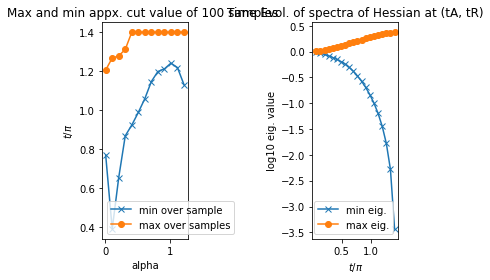

In [14]:
from scipy.optimize import minimize_scalar


m, d = (10, 4)
np.random.seed(0)    
# radius = 0.8*np.pi
alpha = np.zeros(2)
alpha[0] = 1
alpha[1] = .8

man = RealStiefel(
    m, d, alpha=alpha, log_stats=False, log_method='trust-krylov')
k = min(d, m-d)
adim = (d*(d-1))//2
tdim = adim + d*k
np.random.seed(0)    
Y = man.rand()

man.alpha[1] = 0
man.alpha[1] = .01-.1
NALX = 13
NN = 100
res = np.full((NALX, NN), fill_value=np.nan)
for alx in range(NALX):
    np.random.seed(0)
    man.alpha[1] += .1
    # cut_val = np.zeros(NN)
    print('Doing alpha=%f' % man.alpha[1])
    for ii in range(NN):
        xi = man.randvec(Y)

        def make_Q(k):
            Q0 = randn(m, k)
            Q, _ = la.qr(xi - Y@Y.T@xi)
            return Q
        Q = make_Q(d)

        def min_spec(t):
            Y1 = man.exp(Y, t*xi)
            spt = calc_hessian_spec(t*xi, Y1)
            # print(spt)
            return spt[0]*spt[0]

        ret = minimize_scalar(
            min_spec, method='bounded', bounds=(.01*np.pi, 1.4*np.pi))
        if ret['success'] and ret['fun'] < 5e-2:
            # cut_val[ii] = ret['x']
            res[alx, ii] = ret['x']
        else:
            print(ret)
    
    # print(sorted(cut_val))
np.savez_compressed('stiefel_cut_value',  res=res)
NT = 20
time_arr = np.zeros((NT, 3))
for i in range(1, NT+1):
    t = np.pi*1.4*i/NT
    Y1 = man.exp(Y, t*xi)
    spt = sorted(calc_hessian_spec(t*xi, Y1))
    time_arr[i-1, :] = np.array([t/np.pi, spt[0], spt[-1]])
print(time_arr)

import matplotlib.pyplot as plt    
fig = plt.figure(figsize=(4, 20))
fig = plt.figure()
# fig.suptitle('Stiefel manifold n=%d p=%d. Max and min appx. cut value of %d samples ' % (m, d, NN))
ax1 = fig.add_subplot(121)
xax = np.arange(NALX)*.1+.01
ax1.plot(xax, np.nanmin(res, axis=1)/np.pi, marker='x', label='min over sample')
ax1.plot(xax, np.nanmax(res, axis=1)/np.pi, marker='o',
          label='max over samples')
ax1.set(xlabel='alpha', ylabel='$t/\\pi$')
ax1.legend()
ax1.title.set_text('Max and min appx. cut value of %d samples ' % (NN))
ax2 = fig.add_subplot(122)

ax2.plot(time_arr[:, 0], np.log10(np.abs(time_arr[:, 1])), marker='x', label='min eig.')
ax2.plot(time_arr[:, 0], np.log10(np.abs(time_arr[:, 2])),marker='o',
          label='max eig.')
ax2.set(xlabel='$t/\\pi$', ylabel='log10 eig. value')
ax2.legend()
ax2.title.set_text('Time Evol. of spectra of Hessian at (tA, tR)')
fig.tight_layout()
    



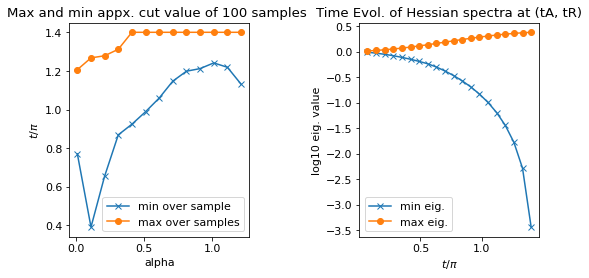

In [59]:
import matplotlib.pyplot as plt    
# fig = plt.figure(figsize=(4, 20))
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
# fig.suptitle('Stiefel manifold n=%d p=%d. Max and min appx. cut value of %d samples ' % (m, d, NN))
# ax1 = fig.add_subplot(121)
plt.rcParams['font.size'] = 11
# fig.clear()
ax1 = axs[0]
xax = np.arange(NALX)*.1+.01
ax1.plot(xax, np.nanmin(res, axis=1)/np.pi, marker='x', label='min over sample')
ax1.plot(xax, np.nanmax(res, axis=1)/np.pi, marker='o',
          label='max over samples')
ax1.set(xlabel='alpha', ylabel='$t/\\pi$')
ax1.legend()
ax1.title.set_text('Max and min appx. cut value of %d samples ' % (NN))
# ax2 = fig.add_subplot(122)
ax2 = axs[1]

ax2.plot(time_arr[:, 0], np.log10(np.abs(time_arr[:, 1])), marker='x', label='min eig.')
ax2.plot(time_arr[:, 0], np.log10(np.abs(time_arr[:, 2])),marker='o',
          label='max eig.')
ax2.set(xlabel='$t/\\pi$', ylabel='log10 eig. value')
# ax2.xlabel('$t/\\pi$', fontsize=18)
# ax2.ylabel('$log10 eig. value$', fontsize=18)
ax2.legend()
ax2.title.set_text('Time Evol. of Hessian spectra at (tA, tR)')
fig.tight_layout()
# plt.annotate(fontsize=1)
# plt.savefig('spectra_hessian_v2.png')

In [27]:
!ls

ManNullRange  sample_data	      stiefel_cut_value.npz
pymanopt      spectra_hessian_v2.png  StiefelGeodesic


# COMPARING EXECUTION TIME, Euclidean distance versus distance and gradient
We show distance + gradient costs typically less than 3 times the cost of evaluating the distance only

## cost of exmp versus expm_frechet

In [28]:
# %pdb
np.random.seed(0)
from scipy.linalg import expm, expm_frechet
N  = 1000
B = np.random.randn(N, N)
B[N:, :] = 0


A = np.random.randn(N, N)
A = A - A.T
A = A/np.linalg.norm(A)*np.pi*.5


%timeit -n 5 expm(A)
%timeit -n 5 expm_frechet(A, B)
# e, _ = np.linalg.eigh(A)
# print(np.max(e), np.min(e))

5 loops, best of 5: 640 ms per loop
5 loops, best of 5: 1.51 s per loop


In [29]:
from scipy.linalg import null_space
def time_fun_val_jac(stf, npi, NAR, N):
    """Inverse of exp

    Parameters
    ----------
    Y    : a manifold point
    Y1  : tangent vector

    Returns
    ----------
    eta such that stf.exp(X, eta) = Y1

    Algorithm: use the scipy.optimize trust region method
    to minimize in eta ||stf.exp(Y, eta) - Y1||_F^2
    _F is the Frobenius norm in R^{n\times d}
    The jacobian could be computed by the expm_frechet function
    """
    alf = stf.alpha[1]/stf.alpha[0]
    d = stf.d
    adim = (d*(d-1))//2
    vals = np.zeros((NAR, N))
    jacs = np.zeros((NAR, N))
    funs = np.zeros((NAR, N))

    for jj in range(N):
        Y = stf.rand()
        xi = stf.randvec(Y)
        Y1 = stf.exp(Y, xi)
        
        def getQ():
            """ algorithm: find a basis in linear span of Y Y1
            orthogonal to Y
            """
            u, s, v = np.linalg.svd(
                np.concatenate([Y, Y1], axis=1), full_matrices=False)
            k = (s > 1e-14).sum()
            good = u[:, :k]@v[:k, :k]
            qs = null_space(Y.T@good)
            Q, _ = np.linalg.qr(good@qs)
            return Q

        Q = getQ()
        k = Q.shape[1]
        ZTY = Y1.T@Y
        ZTQ = Y1.T@Q
        if k == 0:
            # Y1 and Y has the same linear span
            A = logm(Y.T @ Y1)

            if stf.log_stats:
                return Y@A, [('success', True), ('message', 'aligment')]
            return Y@A

        def vec(A, R):
            return np.concatenate(
                [vecah(A), R.reshape(-1)])

        def unvec(avec):
            return unvecah(avec[:adim]), avec[adim:].reshape(k, d)

        def dist(v):
            A, R = unvec(v)
            ex2 = expm(
                sbmat([[2*alf*A, -R.T], [R, np.zeros((k, k))]]))
            M = ex2[:d, :d]
            N = ex2[d:, :d]
            ZYMQN = ZTY@M + ZTQ@N
            return -np.sum(ZYMQN.T*expm((1-2*alf)*A))

        def jac(v):
            A, R = unvec(v)
            ex1 = expm((1-2*alf)*A)

            mat = sbmat([[2*alf*A, -R.T], [R, np.zeros((k, k))]])
            E = sbmat(
                [[ex1@ZTY, ex1@ZTQ],
                 [np.zeros_like(R), np.zeros((k, k))]])

            ex2, fe2 = expm_frechet(mat, E)
            M = ex2[:d, :d]
            N = ex2[d:, :d]
            ZYMQN = ZTY@M+ZTQ@N

            partA = asym(
                (1-2*alf)*expm_frechet((1-2*alf)*A, ZYMQN)[1])

            partA += 2*alf*asym(fe2[:d, :d])
            partR = -(fe2[:d, d:].T - fe2[d:, :d])

            return vec(partA, partR)

        def fun(v):
            A, R = unvec(v)
            ex1 = expm((1-2*alf)*A)

            mat = sbmat([[2*alf*A, -R.T], [R, np.zeros((k, k))]])
            E = sbmat(
                [[ex1@ZTY, ex1@ZTQ],
                 [np.zeros_like(R), np.zeros((k, k))]])

            ex2, fe2 = expm_frechet(mat, E)
            M = ex2[:d, :d]
            N = ex2[d:, :d]
            ZYMQN = ZTY@M+ZTQ@N

            partA = asym(
                (1-2*alf)*expm_frechet((1-2*alf)*A, ZYMQN)[1])

            partA += 2*alf*asym(fe2[:d, :d])
            partR = -(fe2[:d, d:].T - fe2[d:, :d])

            return -np.sum(ZYMQN.T*expm((1-2*alf)*A)),\
                vec(partA, partR)

        from time import perf_counter
        
        for jjj in range(NAR):
            v = np.random.rand(adim + d*k)
            v = v/np.linalg.norm(v)
            t0 = perf_counter()
            dist(v)
            t1 = perf_counter()
            vals[jjj, jj] = t1 - t0

            t0 = perf_counter()
            jac(v)
            t1 = perf_counter()
            jacs[jjj, jj] = t1 - t0
            
            t0 = perf_counter()
            fun(v)
            t1 = perf_counter()
            print("jj=%d jjj=%d time=%f" % (jj, jjj, t1-t0))
            funs[jjj, jj] = t1 - t0
    return vals, jacs, funs


In [30]:
np.random.seed(0)
from scipy.linalg import expm, expm_frechet
alf = .5
n = 1500
d = 1000

alpha = np.array([1, alf])    
stf = RealStiefel(n, d, alpha, log_stats=True, log_method='trust-ncg')
NAR = 10
N = 2
npi = 1
vals, jacs, funs = time_fun_val_jac(stf, npi, NAR, N)
print(vals.mean(axis=1), jacs.mean(axis=1), funs.mean(axis=1))    
print(vals.mean(), jacs.mean(), funs.mean())




jj=0 jjj=0 time=6.221669
jj=0 jjj=1 time=6.162350
jj=0 jjj=2 time=6.241910
jj=0 jjj=3 time=6.191619
jj=0 jjj=4 time=6.157275
jj=0 jjj=5 time=6.181446
jj=0 jjj=6 time=6.152855
jj=0 jjj=7 time=6.200567
jj=0 jjj=8 time=6.184961
jj=0 jjj=9 time=6.173866
jj=1 jjj=0 time=6.215151
jj=1 jjj=1 time=6.176111
jj=1 jjj=2 time=6.203919
jj=1 jjj=3 time=6.199455
jj=1 jjj=4 time=6.192260
jj=1 jjj=5 time=6.136510
jj=1 jjj=6 time=6.194473
jj=1 jjj=7 time=6.189597
jj=1 jjj=8 time=6.202725
jj=1 jjj=9 time=6.165767
[2.2164911  2.1937632  2.21876159 2.23638991 2.22230732 2.24131132
 2.23692707 2.24297164 2.22785665 2.2373954 ] [5.9401661  5.91444437 5.93255967 5.98014424 5.91204095 5.99612679
 5.88706967 5.92364147 5.95866612 5.94516177] [6.21840974 6.16923035 6.22291452 6.19553697 6.17476717 6.15897832
 6.17366376 6.19508203 6.19384332 6.16981679]
2.2274175190500953 5.939002115050061 6.18722429745012


In [31]:
np.random.seed(0)
from scipy.linalg import expm, expm_frechet
alf = .5
n = 1500
d = 500

alpha = np.array([1, alf])    
stf = RealStiefel(n, d, alpha, log_stats=True, log_method='trust-ncg')
NAR = 10
N = 2
npi = 0.5
vals, jacs, funs = time_fun_val_jac(stf, npi, NAR, N)
print(vals.mean(axis=1), jacs.mean(axis=1), funs.mean(axis=1))    
print(vals.mean(), jacs.mean(), funs.mean())




jj=0 jjj=0 time=1.928733
jj=0 jjj=1 time=1.935758
jj=0 jjj=2 time=1.951659
jj=0 jjj=3 time=1.895813
jj=0 jjj=4 time=1.897414
jj=0 jjj=5 time=1.897491
jj=0 jjj=6 time=1.881152
jj=0 jjj=7 time=1.916054
jj=0 jjj=8 time=1.942995
jj=0 jjj=9 time=1.869024
jj=1 jjj=0 time=1.947641
jj=1 jjj=1 time=1.815829
jj=1 jjj=2 time=1.873040
jj=1 jjj=3 time=1.886214
jj=1 jjj=4 time=1.887647
jj=1 jjj=5 time=1.879591
jj=1 jjj=6 time=1.890591
jj=1 jjj=7 time=1.900025
jj=1 jjj=8 time=1.927625
jj=1 jjj=9 time=1.805287
[0.69262946 0.71739145 0.74117745 0.71349517 0.74174704 0.7448589
 0.73171044 0.71692087 0.74154557 0.71409596] [1.82856404 1.82358775 1.80528846 1.82467619 1.80626214 1.79672665
 1.79491093 1.82242868 1.83928228 1.77333472] [1.93818677 1.87579384 1.91234986 1.8910134  1.89253047 1.88854062
 1.88587177 1.9080395  1.93531019 1.83715553]
0.7255572321500494 1.811506184399923 1.896479195799884
